In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

DeltaS =  8.266263554732381
counts =  [ 12 100 172 288 316 302 236 178 114  83  62  43  18   9  14   8   8   8
   3   4   2   2   4   1   3   0   0   0   2   1   0   2   1   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
6.042627315137316


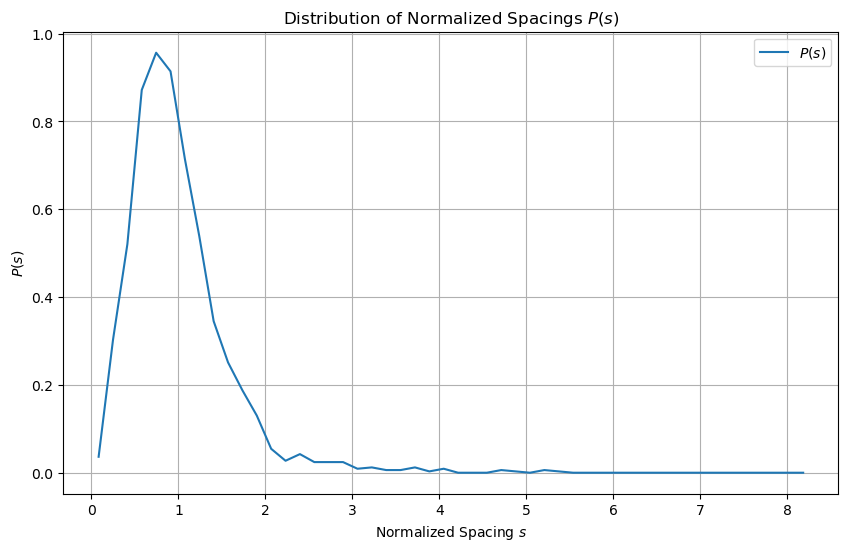

In [55]:
import numpy as np
import matplotlib.pyplot as plt

def generate_random_hermitian_matrix(N, seed):
    np.random.seed(seed)
    real_part = np.random.randn(N, N)  # Real part
    imag_part = np.random.randn(N, N)  # Imaginary part
    A = real_part + 1j * imag_part
    A = np.tril(A) + np.tril(A, -1).T.conj()  # Make Hermitian
    return A

def compute_normalized_spacings(N, seed):
    # Generate Hermitian matrix and compute eigenvalues
    A = generate_random_hermitian_matrix(N, seed)
    eigenvalues = np.linalg.eigh(A)[0]  # Sorted real eigenvalues
    
    # Compute spacings and normalize by mean spacing
    spacings = np.diff(eigenvalues)
    avg_spacing = np.mean(spacings)
    normalized_spacings = spacings / avg_spacing
    return normalized_spacings

def calculate_Ps_distribution(N, num_matrices, N_bins):
    all_normalized_spacings = []
    
    # Accumulate normalized spacings from multiple random matrices
    for i in range(num_matrices):
        seed = i  # Use a different seed for each matrix
        normalized_spacings = compute_normalized_spacings(N, seed)
        all_normalized_spacings.extend(normalized_spacings)
    
    # Convert to numpy array
    all_normalized_spacings = np.array(all_normalized_spacings)
    
    # Range of normalized spacings
    DeltaS = np.max(all_normalized_spacings) - np.min(all_normalized_spacings)
    
    # Create bins and count occurrences in each bin
    counts, bin_edges = np.histogram(all_normalized_spacings, bins=N_bins, range=(0, DeltaS))
    
    print("DeltaS = ", DeltaS)
    print("counts = ", counts)

    # Total number of spacings
    N_tot = len(all_normalized_spacings)
    
    # Width of each bin
    ds = DeltaS / N_bins
    
    # Compute P(s) for each bin
    P_s = counts / (N_tot * ds)

    print(sum(P_s))
    
    # Bin centers for plotting
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    return bin_centers, P_s

def plot_Ps_distribution(bin_centers, P_s):
    plt.figure(figsize=(10, 6))
    plt.plot(bin_centers, P_s, label='$P(s)$')
    plt.title('Distribution of Normalized Spacings $P(s)$')
    plt.xlabel('Normalized Spacing $s$')
    plt.ylabel('$P(s)$')
    plt.legend()
    plt.grid()
    plt.show()

# Example usage:
N = 1000  # Size of each matrix
num_matrices = 2  # Number of random matrices to accumulate data
N_bins = 50  # Number of bins for the histogram

bin_centers, P_s = calculate_Ps_distribution(N, num_matrices, N_bins)
plot_Ps_distribution(bin_centers, P_s)


In [ ]:
def generate_random_hermitian_matrix(N, seed):

    np.random.seed(seed)

    # Generate random complex numbers for the lower triangle, including the diagonal
    real_part = np.random.randn(N, N)  # Real part
    imag_part = np.random.randn(N, N)  # Imaginary part
    
    # Combine to create complex entries
    c = real_part + 1j * imag_part
    
    # Make the matrix Hermitian by taking the lower triangle and mirroring it
    A = np.tril(c) + np.tril(c, -1).T.conj()  # Lower triangle + conjugate transpose of upper
    
    return A

def compute_eigenvalues_and_spacings(N, seed):
    # Generate the random Hermitian matrix
    A = generate_random_hermitian_matrix(N, seed)
    
    # Diagonalize the matrix to get the eigenvalues
    eigenvalues = np.linalg.eigh(A)[0]  # eigh returns sorted eigenvalues for Hermitian matrices
    
    if not np.all(np.isreal(eigenvalues)):
        raise ValueError("Eigenvalues are not all real. Check the Hermitian property of the matrix.")
    
    # Compute spacings (differences between consecutive eigenvalues)
    spacings = np.diff(eigenvalues)  # Include all spacings

    # computation of the normalized spacings
    average = np.mean(spacings)
    norm_spacings = spacings/average
    
    return A, eigenvalues, norm_spacings


def compute_distribution_of_spacings(num_matrices, N):
    all_normalized_spacings = []
    
    for i in range(num_matrices):
        seed = i  # Use a different seed for each matrix
        A, eigenvalues, normalized_spacings = compute_eigenvalues_and_spacings(N, seed)
        all_normalized_spacings.extend(normalized_spacings)
    
    return np.array(all_normalized_spacings)

def plot_distribution(normalized_spacings):
    # Estimate the density of the normalized spacings
    kde = gaussian_kde(normalized_spacings)
    
    # Create a range of values for s
    s_values = np.linspace(0, max(normalized_spacings), 1000)
    density = kde(s_values)
    
    # Plot the distribution
    plt.figure(figsize=(10, 6))
    plt.plot(s_values, density, label='Density of Normalized Spacings $P(s)$')
    plt.title('Distribution of Normalized Spacings $P(s)$')
    plt.xlabel('Normalized Spacing $s$')
    plt.ylabel('Density')
    plt.legend()
    plt.grid()
    plt.show()

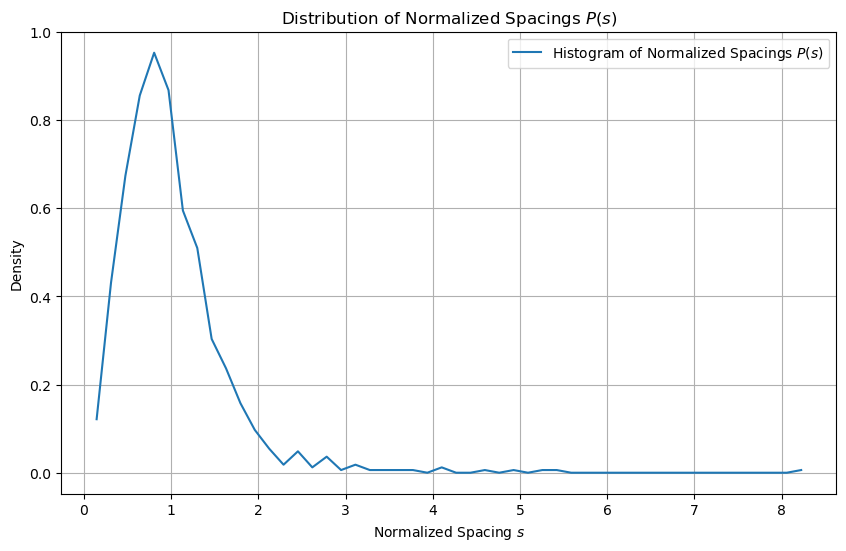

In [47]:
# Example usage:
num_matrices = 1  # Number of random matrices
N = 1000  # Size of each matrix
normalized_spacings = compute_distribution_of_spacings(num_matrices, N)
plot_normalized_histogram(normalized_spacings)

In [38]:
# Example usage:
N = 5  # Matrix size
seed = 12345
A, eigenvalues, norm_spacings = compute_eigenvalues_and_spacings(N, seed)

# in this way A[i,:] access the i-th row, A[:,i] the i-th column

print(A)
print("Eigenvalues (sorted):", eigenvalues)
print("Normalized Spacings:", norm_spacings)

[[-0.20470766+0.12412128j  1.39340583+0.71354399j  1.00718936-0.56014529j
   0.88642934+2.35941881j -0.53974145-0.28634975j]
 [ 1.39340583-0.71354399j  0.09290788-0.83115354j -1.29622111+1.26593449j
  -2.00163731+0.19954296j  0.47698501-0.37798411j]
 [ 1.00718936+0.56014529j -1.29622111-1.26593449j  0.27499163+0.11982712j
  -0.37184254+1.54199553j  3.24894392+0.75388653j]
 [ 0.88642934-2.35941881j -2.00163731-0.19954296j -0.37184254-1.54199553j
   1.66902531-0.97073591j -1.02122752-0.33128565j]
 [-0.53974145+0.28634975j  0.47698501+0.37798411j  3.24894392-0.75388653j
  -1.02122752+0.33128565j -0.5770873 +1.34974221j]]
Eigenvalues (sorted): [-4.89251946 -2.78728517  0.73837735  2.79516125  5.40139588]
Normalized Spacings: [0.81804997 1.36999864 0.79922317 1.01272822]
